# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, isnan, when, count, col,trim
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from tabulate import tabulate
import datetime
import pyspark
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as f
from pyspark.sql.functions import from_unixtime, countDistinct, avg, max, min, date_format, unix_timestamp, dayofweek
from pyspark.sql import Window
from pyspark.sql import types
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import Imputer, StringIndexer, StringIndexerModel, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.feature import StandardScaler, OneHotEncoderModel
from pyspark.ml.feature import StringIndexer
import threading
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Read in the dataset
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [4]:
# Print Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Print first record for EDA
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [6]:
# Remove empty User IDs
df = df.filter(df.userId != '')

In [7]:
def missing_perc(df, cols, nrows):
    '''
    INPUT:
    df - (spark dataframe) df as defined at the top of the notebook 
    cols - (list) list of columns for which we want to check missing values
    nrows - (int) count of number of rows in dataframe
    
    OUTPUT:
    missing_df_perc - (pandas dataframe) Dataframe of number of missing values and percentages
    '''
    missing_df = df.select([count(when(isnan(c) | df[c].isNull() | (trim(df[c]) == ''), c)).alias(c) for c in cols])
    missing_df_perc = spark.createDataFrame([(missing_df.columns[c], missing_df.collect()[0][c],
                                                      round(float(missing_df.collect()[0][c]) / float(nrows) * 100, 6)) for
                                                     c in range(len(cols))],
                                                    ["col_name", "missing_count", "missing_percen"])
    missing_df_perc = missing_df_perc.orderBy('missing_percen', ascending=False)
    x = missing_df_perc.toPandas()
    print("Missing count and percentages:\n" + tabulate(x, headers='keys', tablefmt='psql'))
    return missing_df_perc

In [8]:
# Define columns and count rows
ids = ['firstName','lastName','song']
cols = ['userId','auth','gender','itemInSession','length','level','location','method','page','registration','sessionId','status','ts','userAgent','userId']
nrows = df.count()

In [9]:
missing_perc(df,cols,nrows)

Missing count and percentages:
+----+---------------+-----------------+------------------+
|    | col_name      |   missing_count |   missing_percen |
|----+---------------+-----------------+------------------|
|  0 | length        |           50046 |          17.9922 |
|  1 | userId        |               0 |           0      |
|  2 | auth          |               0 |           0      |
|  3 | gender        |               0 |           0      |
|  4 | itemInSession |               0 |           0      |
|  5 | level         |               0 |           0      |
|  6 | location      |               0 |           0      |
|  7 | method        |               0 |           0      |
|  8 | page          |               0 |           0      |
|  9 | registration  |               0 |           0      |
| 10 | sessionId     |               0 |           0      |
| 11 | status        |               0 |           0      |
| 12 | ts            |               0 |           0      |
| 13 | us

DataFrame[col_name: string, missing_count: bigint, missing_percen: double]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# Creating 'Churn' column
df = df.withColumn('Churn', f.when(f.col('page') == 'Cancellation Confirmation', 1).otherwise(0))

In [11]:
# Setting up the window
range_begin = Window.unboundedPreceding
range_end = Window.unboundedFollowing
window_users = Window.partitionBy("userId").rangeBetween(range_begin, range_end)
df = df.withColumn("Churn",f.sum("Churn").over(window_users))

In [12]:
# Count users who churned (1) v/s those who didn't (0)
df.select('userId','Churn').dist7inct().groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [13]:
#Churn w.r.t gender
no_gender = df.select('userId','gender','Churn').distinct().groupBy('gender','Churn').count()

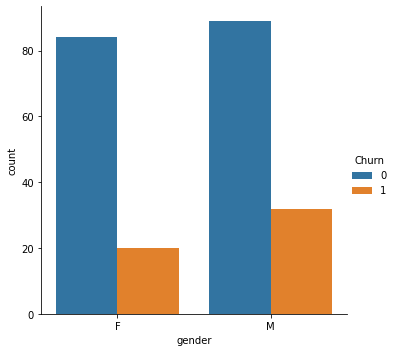

In [14]:
sns.catplot(x = 'gender', y = 'count',hue = 'Churn', data = no_gender.toPandas(), kind = 'bar');

In [15]:
# Churn w.r.t auth
no_auth = df.select('userId','auth','Churn').distinct().groupBy('auth','Churn').count()

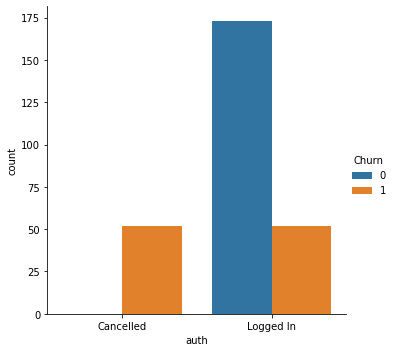

In [16]:
sns.catplot(x = 'auth', y = 'count',hue = 'Churn', data = no_auth.toPandas(), kind = 'bar');

As expected, Churned users will ofcourse not be logged in, so this attribute does not affect Churn

In [17]:
# Churn w.r.t level
no_level = df.select('userId','level','Churn').distinct().groupBy('level','Churn').count()

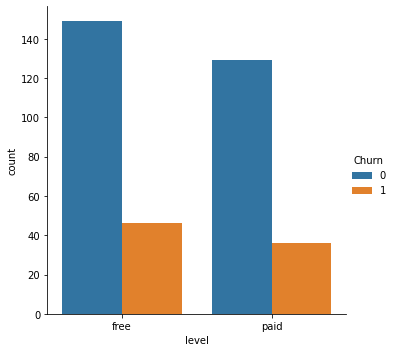

In [18]:
sns.catplot(x = 'level', y = 'count',hue = 'Churn', data = no_level.toPandas(), kind = 'bar');

In [19]:
# Split location column into city and state
split_col = pyspark.sql.functions.split(df['location'], ',')
df = df.withColumn('user_city',split_col.getItem(0))
no_city = df.select('userId','user_city').distinct().groupBy('user_city').count().orderBy('count', ascending = False)
df = df.withColumn('user_state',split_col.getItem(1))
no_loc = df.select('userId','user_state').distinct().groupBy('user_state').count().orderBy('count', ascending = False)

Text(0.5, 1.0, 'Top 10 States')

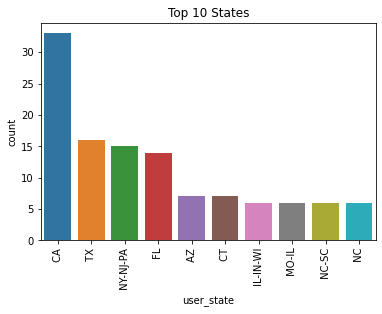

In [20]:
sns.barplot(x = 'user_state', y = 'count', data = no_loc.toPandas().head(10));
plt.xticks(rotation=90)
plt.title('Top 10 States')

Text(0.5, 1.0, 'Top 15 cities')

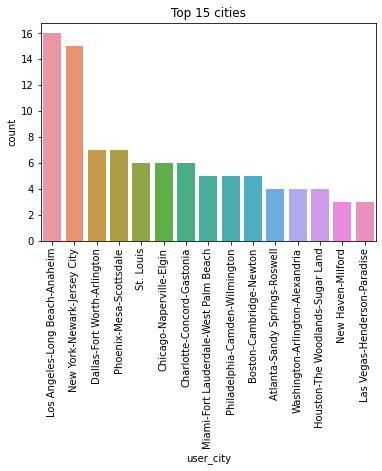

In [21]:
sns.barplot(x = 'user_city', y = 'count', data = no_city.toPandas().head(15));
plt.xticks(rotation=90)
plt.title('Top 15 cities')

In [22]:
# Churn w.r.t State
state_churn = df.select('userId','user_state','Churn').distinct().groupBy('user_state','Churn').count().orderBy('user_state','count', ascending = True)

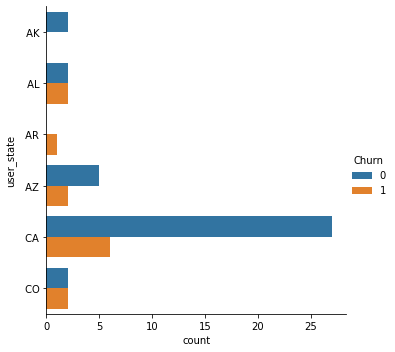

In [23]:
sns.catplot(y = 'user_state', x = 'count',hue = 'Churn', data = state_churn.toPandas().head(10), kind = 'bar', orient = "h");


In [24]:
# Create new columns based on timestamp column
df = df.withColumn("Hour_of_day", from_unixtime("ts", "HH"))
df = df.withColumn('day_of_month',(from_unixtime("ts", "dd")))

In [25]:
# Drop columns that are unnecessary
df = df.drop('firstName','lastName','method','status','registration','auth', 'location')

In [26]:
# Print updated schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: long (nullable = true)
 |-- user_city: string (nullable = true)
 |-- user_state: string (nullable = true)
 |-- Hour_of_day: string (nullable = true)
 |-- day_of_month: string (nullable = true)



In [27]:
# Grouping Users by Session Id and Churn
unique_sessions_by_id = ((df.groupBy('userId','Churn').agg(countDistinct('sessionId')).orderBy('userId')).toPandas())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f943f40>,
      dtype=object)

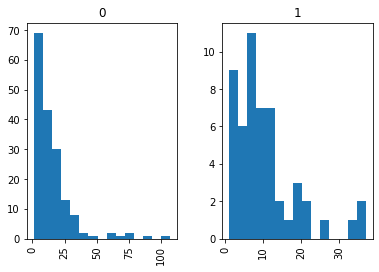

In [28]:
unique_sessions_by_id['count(sessionId)'].hist(by =  unique_sessions_by_id['Churn'], bins = 15 )

In [29]:
# Grouping Users by Average Song Length and Churn
avg_length_songs_by_id = ((df.groupBy('userId','Churn').agg(avg('length')).orderBy('userId')).toPandas())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f6c97f0>,
      dtype=object)

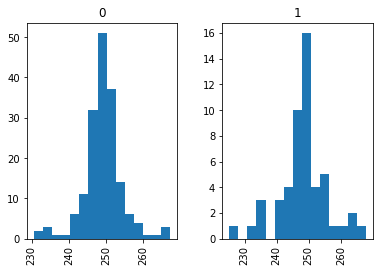

In [30]:
avg_length_songs_by_id['avg(length)'].hist(by =  avg_length_songs_by_id['Churn'], bins = 15 )

Non Churners seem to be listening more as seen in the histograms above

In [31]:
# Grouping Users by Hour of Day and Churn
hh_churn = df.groupBy('Hour_of_day','Churn').count().orderBy('Hour_of_day')

In [32]:
# Grouping Users by Day of Month and Churn
dom_churn = df.groupBy('day_of_month','Churn').count().orderBy('day_of_month')

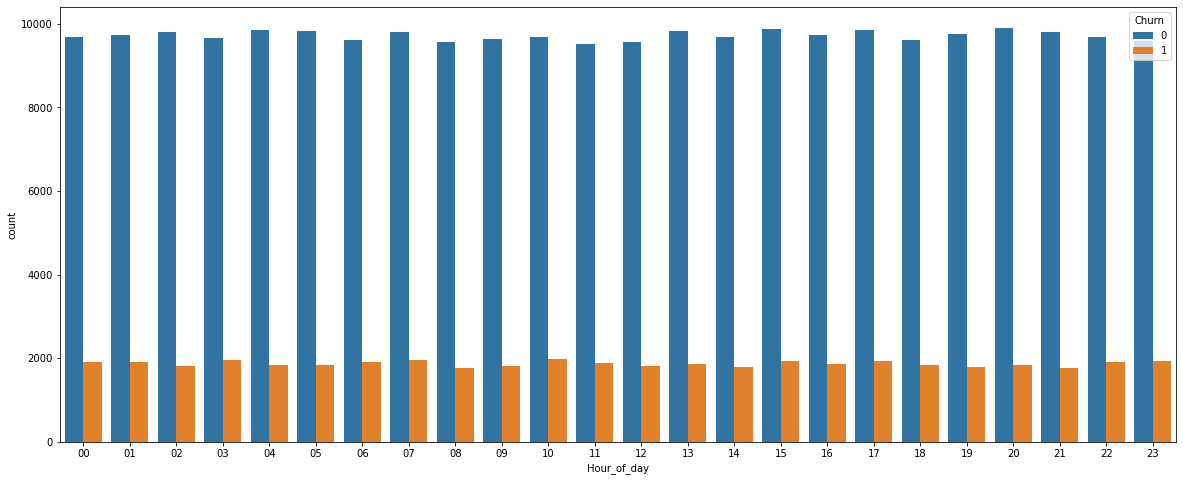

In [33]:
plt.figure(figsize=(20,8))
sns.barplot(x = 'Hour_of_day', y = 'count', hue = 'Churn', data = hh_churn.toPandas());

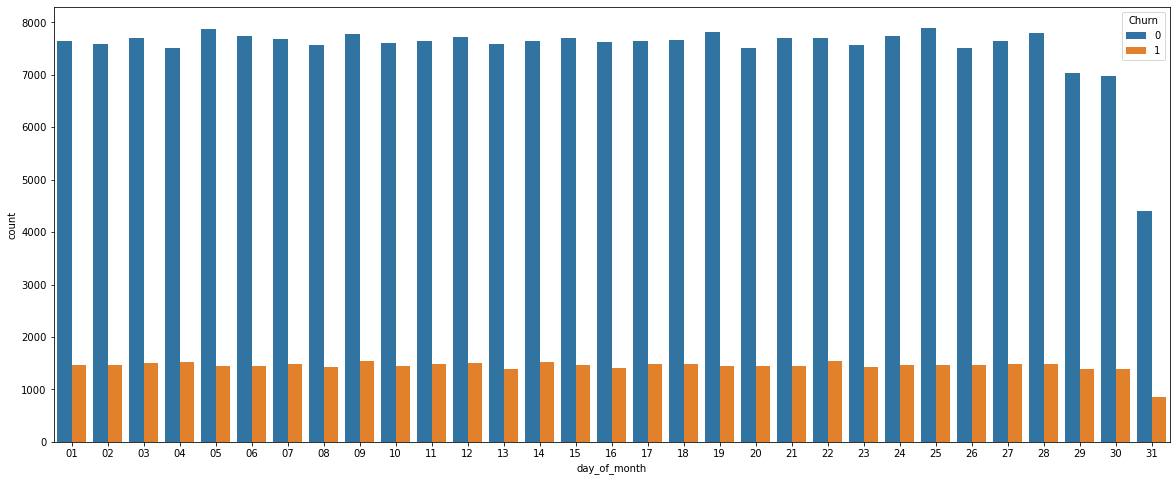

In [34]:
plt.figure(figsize=(20,8))
sns.barplot(x = 'day_of_month', y = 'count', hue = 'Churn', data = dom_churn.toPandas());

In [35]:
# Grouping Users by Unique Artists and Churn
unique_artist_by_id = ((df.groupBy('userId','Churn').agg(countDistinct('artist')).orderBy('userId')).toPandas())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1202bbbe0>,
      dtype=object)

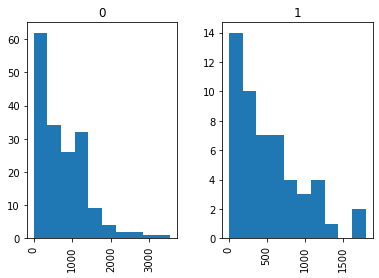

In [36]:
unique_artist_by_id['count(artist)'].hist(by =  unique_artist_by_id['Churn'] )

Churners (1) tend to listen to fewer artists

In [37]:
# Grouping Users by Unique songs and Churn
unique_songs_by_id = ((df.groupBy('userId','Churn').agg(countDistinct('song')).orderBy('userId')).toPandas())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x120597490>,
      dtype=object)

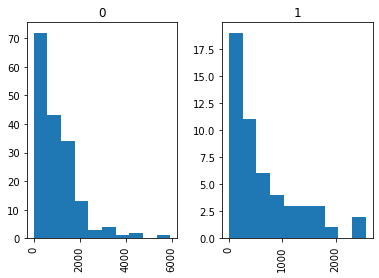

In [38]:
unique_songs_by_id['count(song)'].hist(by =  unique_songs_by_id['Churn'] )

No surprises when Churners (1) tend to listen to fewer songs

In [39]:
# Grouping Users by Type of Page and Churn
page_churn = df.groupBy('page', 'Churn').count().orderBy('count', ascending = False)

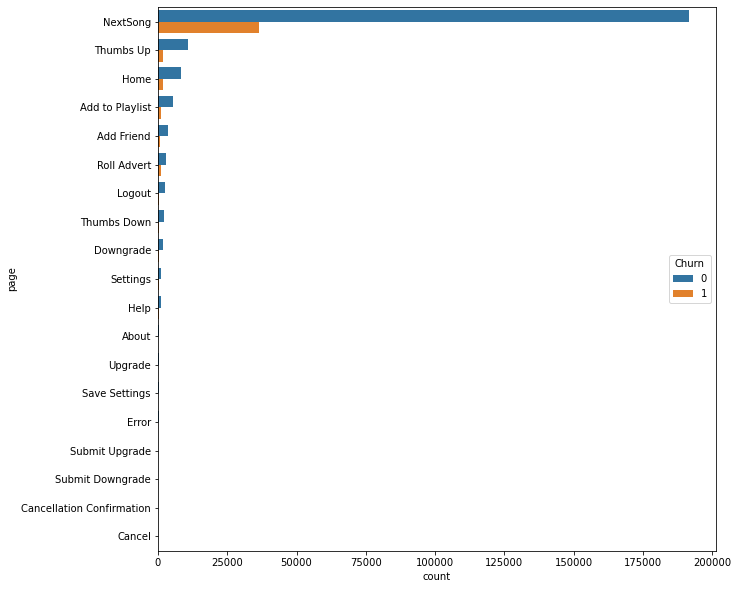

In [40]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'count', y = 'page', hue = 'Churn', data = page_churn.toPandas(), orient='h');

In [41]:
#Splitting userAent to get Device Type
df = df.withColumn("_tmp", pyspark.sql.functions.split("userAgent", "\\;").getItem(0))
df = df.withColumn("tmp2", pyspark.sql.functions.split("_tmp", "\\(").getItem(1))
df = df.withColumn("device_type", pyspark.sql.functions.split("tmp2", "\\)").getItem(0))
df = df.drop('_tmp', 'tmp2', 'userAgent')

In [42]:
device_churn =  df.groupBy('device_type', 'Churn').count().orderBy('count', ascending = False)

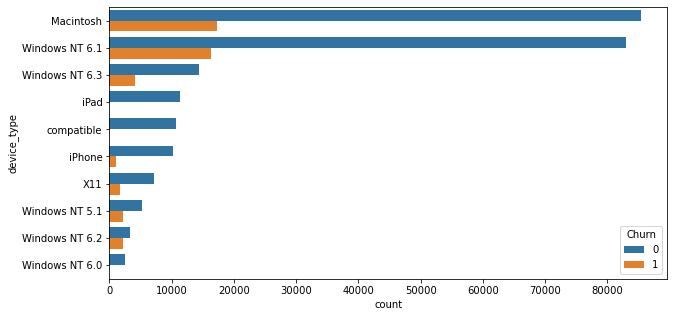

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'count', y = 'device_type', hue = 'Churn', data = device_churn.toPandas(), orient='h');


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

The features that I am creating include:
    1. No of unique sessions per user
    2. Activity during AM Hours
    3. Activity during PM Hours
    4. Average song length
    5. Longest session by the user
    6. User State
    7. User City
    8. No. of Next Song events
    9. No. of Thumbs up counts
    10. No of Thumbs Down counts
    11. No of Playlist added events
    12. No of friend added events
    13. Downgrade evnts per user
    14. Acivity during first half of the month
    15. Activity during second half of the month
    16. Home Click count
    17. Type of Device

In [44]:
# Print Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: long (nullable = true)
 |-- user_city: string (nullable = true)
 |-- user_state: string (nullable = true)
 |-- Hour_of_day: string (nullable = true)
 |-- day_of_month: string (nullable = true)
 |-- device_type: string (nullable = true)



In [47]:
# Engineering new features as defined above

final_df = ((df.groupBy('userId','Churn','gender','user_city','user_state', 'device_type')
       .agg(countDistinct('sessionId').alias('unique_sess'),
        count(when(col("Hour_of_day") >= 12,1)).alias('PM_count'),
        count(when(col("Hour_of_day") < 12,1)).alias('AM_count'),
        count(when(col("day_of_month") < 15,1)).alias('first_half_month'),
        count(when(col("day_of_month") >= 15,1)).alias('second_half_month'),
        avg('length').alias('avg_song_length'), 
        max('itemInSession').alias('longest_sess'),
        count(when(col("page") == 'NextSong',1)).alias('next_song_count'),
        count(when(col("page") == 'Thumbs Up',1)).alias('thumbs_up_count'),
        count(when(col("page") == 'Thumbs Down',1)).alias('thumbs_down_count'),
        count(when(col("page") == 'Add to Playlist',1)).alias('playlist_added_count'),
        count(when(col("page") == 'Add Friend',1)).alias('friend_added_count'),
        count(when(col("page") == 'Downgrade',1)).alias('Downgrade_count'),
        count(when(col("page") == 'Home',1)).alias('home_click_count'),
        count(when(col("page") == 'Roll Advert',1)).alias('roll_advert_count'),
        )
       .orderBy('userId')))



In [48]:
# Print Schema for new features
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Churn: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- user_city: string (nullable = true)
 |-- user_state: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- unique_sess: long (nullable = false)
 |-- PM_count: long (nullable = false)
 |-- AM_count: long (nullable = false)
 |-- first_half_month: long (nullable = false)
 |-- second_half_month: long (nullable = false)
 |-- avg_song_length: double (nullable = true)
 |-- longest_sess: long (nullable = true)
 |-- next_song_count: long (nullable = false)
 |-- thumbs_up_count: long (nullable = false)
 |-- thumbs_down_count: long (nullable = false)
 |-- playlist_added_count: long (nullable = false)
 |-- friend_added_count: long (nullable = false)
 |-- Downgrade_count: long (nullable = false)
 |-- home_click_count: long (nullable = false)
 |-- roll_advert_count: long (nullable = false)



In [49]:
print(final_df.toPandas())

     userId  Churn gender                              user_city user_state  \
0        10      0      M                                 Laurel         MS   
1       100      0      M            Dallas-Fort Worth-Arlington         TX   
2    100001      1      F  Miami-Fort Lauderdale-West Palm Beach         FL   
3    100002      0      F              Santa Maria-Santa Barbara         CA   
4    100003      1      F  Miami-Fort Lauderdale-West Palm Beach         FL   
..      ...    ...    ...                                    ...        ...   
220      95      0      F                Phoenix-Mesa-Scottsdale         AZ   
221      96      0      F                Atlantic City-Hammonton         NJ   
222      97      0      F       Riverside-San Bernardino-Ontario         CA   
223      98      0      M       Houston-The Woodlands-Sugar Land         TX   
224      99      0      F                      New Haven-Milford         CT   

        device_type  unique_sess  PM_count  AM_coun

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [50]:
# Counting no of rows(users)
cols_final = list(final_df.columns)
cols_count = final_df.count()

In [51]:
# Checking missing values for new dataframe
missing_perc(final_df, cols_final, cols_count)

Missing count and percentages:
+----+----------------------+-----------------+------------------+
|    | col_name             |   missing_count |   missing_percen |
|----+----------------------+-----------------+------------------|
|  0 | userId               |               0 |                0 |
|  1 | Churn                |               0 |                0 |
|  2 | gender               |               0 |                0 |
|  3 | user_city            |               0 |                0 |
|  4 | user_state           |               0 |                0 |
|  5 | device_type          |               0 |                0 |
|  6 | unique_sess          |               0 |                0 |
|  7 | PM_count             |               0 |                0 |
|  8 | AM_count             |               0 |                0 |
|  9 | first_half_month     |               0 |                0 |
| 10 | second_half_month    |               0 |                0 |
| 11 | avg_song_length      |  

DataFrame[col_name: string, missing_count: bigint, missing_percen: double]

In [52]:
# Setting up various columns
id_cols = ['userId']
cat_cols = ['gender','user_city','user_state']
num_cols = ['unique_sess','PM_count','AM_count','first_half_month','second_half_month','avg_song_length',
           'longest_sess','next_song_count','thumbs_up_count','thumbs_down_count','playlist_added_count',
           'friend_added_count','Downgrade_count','home_click_count','roll_advert_count']

In [53]:
# Converting column datatypes to Double
for col in num_cols + ['Churn']:
    final_df = final_df.withColumn(col, final_df[col].cast(types.DoubleType()))

In [54]:
# Print Schema
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Churn: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- user_city: string (nullable = true)
 |-- user_state: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- unique_sess: double (nullable = false)
 |-- PM_count: double (nullable = false)
 |-- AM_count: double (nullable = false)
 |-- first_half_month: double (nullable = false)
 |-- second_half_month: double (nullable = false)
 |-- avg_song_length: double (nullable = true)
 |-- longest_sess: double (nullable = true)
 |-- next_song_count: double (nullable = false)
 |-- thumbs_up_count: double (nullable = false)
 |-- thumbs_down_count: double (nullable = false)
 |-- playlist_added_count: double (nullable = false)
 |-- friend_added_count: double (nullable = false)
 |-- Downgrade_count: double (nullable = false)
 |-- home_click_count: double (nullable = false)
 |-- roll_advert_count: double (nullable = false)



In [55]:
# Setup pipeline
features_t = {}
features_pipe = {}
def feature_setup(col, es):
    pipe = Pipeline(stages=es)
    features_pipe[col] = pipe.fit(final_df.select(final_df[col]))

In [56]:
# String Indexing and One Hot Encoding of Features,a long with Threading
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol= col + '_index')
    ohe_encoder = OneHotEncoder(dropLast=True, inputCol= col + '_index', outputCol=col+'_ohe')
    features_t[col] = threading.Thread(target=feature_setup, args=[col, [indexer, ohe_encoder]])
    features_t[col].start()
    
for col in cat_cols: 
    features_t[col].join()

In [57]:
# Creating a Vector Assembler of features and Scaling the features
vector_inputs = [col + '_ohe' for col in cat_cols] + num_cols
vector_assembler_features = VectorAssembler(inputCols=vector_inputs, outputCol='features_vector')
scaler = StandardScaler(inputCol='features_vector', outputCol='features')

In [58]:
# Transformation Pipeline i.e. applying previous steps on data
feature_transformation = Pipeline(stages=list(features_pipe.values()) + 
                                  [vector_assembler_features,scaler]) \
            .fit(final_df.select(num_cols + cat_cols))

In [59]:
# Label of features
feature_labels = spark.sparkContext.parallelize( \
            [[col, m.stages[0].labels] for col, m in features_pipe.items()] \
            ).toDF(['Name_of_Feature', 'Value_of_feature'])

In [60]:
feature_labels.show()

+---------------+--------------------+
|Name_of_Feature|    Value_of_feature|
+---------------+--------------------+
|     user_state|[ CA,  TX,  NY-NJ...|
|      user_city|[Los Angeles-Long...|
|         gender|              [M, F]|
+---------------+--------------------+



In [61]:
def feature_transformation_fn(df, feature_transformation):
    '''
    INPUT:
    df - (spark dataframe) Dataframe containing new engineered features
    feature_transformation (pipeline) - Transformation pipeline
    
    OUTPUT:
    final_transformed - (spark dataframe) Transformed spark dataframe
    '''
    feature_labels = {}
    for stage in feature_transformation.stages:
        if isinstance(stage, PipelineModel) and len(stage.stages) > 0:
            stageInner = stage.stages[0]
            if isinstance(stageInner, StringIndexerModel):
                inputCol = stageInner.extractParamMap()[stageInner.getParam('inputCol')]
                ip_labels = stageInner.labels
                outputCol = stageInner.extractParamMap()[stageInner.getParam('outputCol')]
                feature_labels[inputCol]=ip_labels

    if len(feature_labels) > 0:
        def not_seen(labels):
            return f.udf(lambda col_value: col_value if col_value in labels else labels[0])

        not_seen_l = {}
        for col in df.columns:
            if col in num_cols: 
                not_seen_l[col] = df[col]
            elif col in cat_cols: 
                not_seen_l[col] = not_seen(feature_labels[col])(df[col]).alias(col)
        n_unseen = df.select(id_cols + list(not_seen_l.values()) + ['Churn'])
    else:
        n_unseen = df

    # Transform data
    final_transformed = feature_transformation.transform(n_unseen)

    return final_transformed

In [62]:
# Get the transformed dataframe
transformed_df = feature_transformation_fn(final_df, feature_transformation)

In [63]:
#Split the data into train, validation and test set in the ratio 0.8:0.1:0.1
train_df, validation_df, test_df = transformed_df.randomSplit([0.7,0.1,0.1], 42)

### ALGO 1: RANDOM FORSEST CLASSIFIER

In [64]:
# Defining Random Forest Classifier
rfc_classifier = RandomForestClassifier(maxDepth=3, labelCol='Churn', featuresCol='features', seed=42)

In [65]:
# Setting up the parameter grid and Evaluator
param_grid = ParamGridBuilder() \
        .addGrid(rfc_classifier.numTrees,[3,4,5]) \
        .addGrid(rfc_classifier.maxDepth, [4,5,6]) \
        .addGrid(rfc_classifier.maxBins, [5,6,7]) \
        .build()

evaluator = BinaryClassificationEvaluator( \
          rawPredictionCol = "prediction"
          ,labelCol = 'Churn' \
          ,metricName = 'areaUnderROC')

In [66]:
# Setting up the cross validator
cross_validator = CrossValidator( \
          estimatorParamMaps = param_grid \
          ,estimator = rfc_classifier \
          ,evaluator = evaluator \
          ,numFolds = 4 )

In [67]:
# Run the cross validated pipeline and choose the best model
pipeline_model = Pipeline(stages=[cross_validator]).fit(train_df)
cv_model = pipeline_model.stages[0]
model = cv_model.bestModel

In [68]:
# Print Optimal Parameters
optimal_params = pd.DataFrame({
          'Number of Trees': [model.getNumTrees]
          ,'Max Depth': [model.getMaxDepth()]
          ,'Max Bins': [model.getMaxBins()]
          })
print(optimal_params)

   Number of Trees  Max Depth  Max Bins
0                4          4         6


In [69]:
def metric_fn(df, model, data_type):
    '''
    INPUT:
    df - (spark dataframe) input dataframe for which we need metrics
    model - (model) The actual trained model
    data_type - (text) Can be Train, Validation, Test wtc.
    
    OUTPUT:
    none
    '''
    transformed_df = model.transform(df)
    results = transformed_df.select(['prediction', 'Churn'])
    predictionAndLabels=results.rdd
    metrics = MulticlassMetrics(predictionAndLabels)
    cm=metrics.confusionMatrix().toArray()
    accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    precision=(cm[0][0])/(cm[0][0]+cm[1][0])
    recall=(cm[0][0])/(cm[0][0]+cm[0][1])
    f1_s = (2 * precision * recall)/(precision + recall)
    print(data_type + ' METRICS')
    print('Confusion Matrix: \n',cm )
    print('Area under ROC:' ,evaluator.evaluate(transformed_df, {evaluator.metricName: "areaUnderROC"}))
    print('Accuracy: ',accuracy)
    print('Precision: ',precision)
    print('Recall: ',recall)
    print('F1 Score: ',f1_s)
    #return cm, accuracy, precision, recall, f1_s

In [70]:
# Metrics on Training Set
metric_fn(train_df, model, 'TRAIN')

TRAIN METRICS
Confusion Matrix: 
 [[142.   0.]
 [ 34.   2.]]
Area under ROC: 0.5277777777777778
Accuracy:  0.8089887640449438
Precision:  0.8068181818181818
Recall:  1.0
F1 Score:  0.8930817610062893


In [71]:
# Metrics on Validation Set
metric_fn(validation_df, model, 'VALIDATION')

VALIDATION METRICS
Confusion Matrix: 
 [[16.  0.]
 [ 9.  0.]]
Area under ROC: 0.5
Accuracy:  0.64
Precision:  0.64
Recall:  1.0
F1 Score:  0.7804878048780487


In [72]:
# Metrics on Test Set
metric_fn(test_df, model, 'TEST')

TEST METRICS
Confusion Matrix: 
 [[15.  0.]
 [ 7.  0.]]
Area under ROC: 0.5
Accuracy:  0.6818181818181818
Precision:  0.6818181818181818
Recall:  1.0
F1 Score:  0.8108108108108109


### ALGO 2: DECISION TREE CLASSIFIER

In [73]:
# Defining Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
dc_classifier = DecisionTreeClassifier(maxDepth=3, labelCol='Churn', featuresCol='features', seed=42)

In [74]:
# Setting up the parameter grid and Evaluator
param_grid_2 = ParamGridBuilder() \
        .addGrid(dc_classifier.maxDepth, [3,4,5]) \
        .addGrid(dc_classifier.maxBins, [30,40,50]) \
        .build()

In [75]:
# Setting up the cross validator
cross_validator_2 = CrossValidator( \
          estimatorParamMaps = param_grid_2 \
          ,estimator = dc_classifier \
          ,evaluator = evaluator \
          ,numFolds = 4 )

In [76]:
# Run the cross validated pipeline and choose the best model
pipeline_model_2 = Pipeline(stages=[cross_validator_2]).fit(train_df)
cv_model_2 = pipeline_model_2.stages[0]
model_2 = cv_model_2.bestModel

In [77]:
# Print Optimal Parameters
optimal_params_2 = pd.DataFrame({
          'Max Depth': [model_2.getMaxDepth()]
          ,'Max Bins': [model_2.getMaxBins()]
          })
print(optimal_params_2)

   Max Depth  Max Bins
0          3        40


In [78]:
# Metrics on Training Set
metric_fn(train_df, model_2, 'TRAIN')

TRAIN METRICS
Confusion Matrix: 
 [[141.   1.]
 [ 25.  11.]]
Area under ROC: 0.6492566510172144
Accuracy:  0.8539325842696629
Precision:  0.8493975903614458
Recall:  0.9929577464788732
F1 Score:  0.9155844155844155


In [79]:
# Metrics on Validation Set
metric_fn(validation_df, model_2, 'VALIDATION')

VALIDATION METRICS
Confusion Matrix: 
 [[16.  0.]
 [ 8.  1.]]
Area under ROC: 0.5555555555555556
Accuracy:  0.68
Precision:  0.6666666666666666
Recall:  1.0
F1 Score:  0.8


In [80]:
# Metrics on Test Set
metric_fn(test_df, model_2, 'TEST')

TEST METRICS
Confusion Matrix: 
 [[13.  2.]
 [ 6.  1.]]
Area under ROC: 0.5047619047619047
Accuracy:  0.6363636363636364
Precision:  0.6842105263157895
Recall:  0.8666666666666667
F1 Score:  0.7647058823529413


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.